<a href="https://colab.research.google.com/github/Kaustavee/CodeAlpha_Project_Kaustavee_Ghosh/blob/main/Copy_of_LINEAR_REGRESSION_housing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'usa-housing:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7039%2F10115%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240821%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240821T030330Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D836404e6ed594e777bcb718370840163bafab96c23881b015f8edb4141d034339955384bde1e332054757f30dfa78444a8d20fabe960d429e7898477846d0f6decc5e8e38dc781fa7e7e26bda5e875b73e1957f2c2d0faf1a81d196bef2cfefa052a0a86213ecb99987aeb493be1a7b5d51781616a21093c994e8b126ad07ac2826913f3bd782b6b39bcb34cc3a219127aa32e500f320366d7220216428755ae8ab3094ad58250d929713c21372bb437835b6c6480e8cc956a8a9142a26cb4e5ea4ac1a510966b3bc155093c662d18672bf541003e1047dca3ffb9d90b2123831b0a0709e3c76e32a5aca3f7efc96d991ced4c2e64c7c91bed3c4254a64694eb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 371432 bytes downloaded
Downloaded and uncompressed: usa-housing
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usa-housing/USA_Housing.csv


# LINEAR REGRESSION TESTS ON A HOUSING DATASET

> COLUMNS-
> Avg. Area Income
> Avg. Area House Age
> Avg. Area Number of Rooms
> Avg. Area Number of Bedrooms
> Area Population
> Price
> Address

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv("/kaggle/input/usa-housing/USA_Housing.csv")

In [5]:
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              5000 non-null   float64
 1   Avg. Area House Age           5000 non-null   float64
 2   Avg. Area Number of Rooms     5000 non-null   float64
 3   Avg. Area Number of Bedrooms  5000 non-null   float64
 4   Area Population               5000 non-null   float64
 5   Price                         5000 non-null   float64
 6   Address                       5000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 273.6+ KB


In [7]:
df.describe()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,68583.108984,5.977222,6.987792,3.981330,36163.516039,1.232073e+06
std,10657.991214,0.991456,1.005833,1.234137,9925.650114,3.531176e+05
min,17796.631190,2.644304,3.236194,2.000000,172.610686,1.593866e+04
25%,61480.562388,5.322283,6.299250,3.140000,29403.928702,9.975771e+05
50%,68804.286404,5.970429,7.002902,4.050000,36199.406689,1.232669e+06
75%,75783.338666,6.650808,7.665871,4.490000,42861.290769,1.471210e+06
max,107701.748378,9.519088,10.759588,6.500000,69621.713378,2.469066e+06


In [8]:
df.columns

Index(['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
       'Avg. Area Number of Bedrooms', 'Area Population', 'Price', 'Address'],
      dtype='object')

In [9]:
X = df[['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
       'Avg. Area Number of Bedrooms', 'Area Population']]
y = df['Price']

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=101)

In [12]:
X_train

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population
1303,68091.179676,5.364208,7.502956,3.10,44557.379656
1051,75729.765546,5.580599,7.642973,4.21,29996.018448
4904,70885.420819,6.358747,7.250241,5.42,38627.301473
931,73386.407340,4.966360,7.915453,4.30,38413.490484
4976,75046.313791,5.351169,7.797825,5.23,34107.888619
...,...,...,...,...,...
4171,56610.642563,4.846832,7.558137,3.29,25494.740298
599,70596.850945,6.548274,6.539986,3.10,51614.830136
1361,55621.899104,3.735942,6.868291,2.30,63184.613147
1547,63044.460096,5.935261,5.913454,4.10,32725.279544


In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
lm = LinearRegression()

In [15]:
lm.fit(X_train, y_train)

LinearRegression()

In [16]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['coefficient'])

In [17]:
coeff_df

,coefficient
Avg. Area Income,21.528276
Avg. Area House Age,164883.282027
Avg. Area Number of Rooms,122368.678027
Avg. Area Number of Bedrooms,2233.801864
Area Population,15.150420


In [18]:
predictions = lm.predict(X_test)

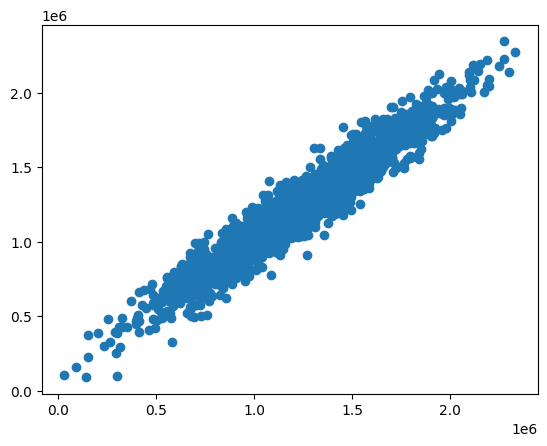

In [19]:
plt.scatter(y_test, predictions)

# **THE LINEARITY IN THE SCATTER PLOT PROVIDES THE INSIGHT THAT OUR MODEL HAS PREDICTED THE REGRESSION ANLAYSIS WELL**